In [21]:
import numpy as np

nfl = 3
ndir = 3
corr = []

#Reading inputs
with open("/Users/manuel/Desktop/pisa_corrs/pisa_b3.85/nissa_mu0.140/meson_corrs", "r") as f:
    read_next = False
    Nt = 0
    tot = 0
    for line in f:
        if ("iop 2" in line or "iop 3" in line or "iop 4" in line):
            read_next = True 
        elif ("#" in line and ("iop 2" not in line or "iop 3" not in line or "iop 4" not in line)):
            read_next = False
        elif read_next:
            if not line.strip():
                Nt = 0;
            if line.strip():
                columns = line.split()
                corr.append(columns[1])
                Nt += 1
                tot +=1
                #print(columns[1])
                
             
NConf = int(tot/(nfl*ndir*Nt))
print("Nt =", Nt,", NConf =",NConf, ", TotDim = ", tot)
print(len(corr))

print(corr[9])

Ar = np.zeros(10)
for i in range(10):
    Ar[i] = corr[i]
print(Ar)
    
#Dividing them in categories 
corr_2 = np.zeros((int(NConf), Nt, nfl, ndir))
for c in range(int(NConf)):
     for k in range(ndir):
        for j in range(nfl):
            for i in range(Nt):
                corr_2[c][i][j][k] = corr[c*Nt*nfl*ndir + k*nfl*Nt + j*Nt + i]

            
print("Dimensions of corr_2: ", len(corr_2), " x ", len(corr_2[0]), " x ", len(corr_2[0][0]), " x ", len(corr_2[0][0][0]))

print(corr_2[0][9][0][0], corr_2[55][9][2][2])

Ar2 = np.zeros(10)
for i in range(10):
    Ar2[i] = corr_2[10][9][0][2]
print(Ar2)

Nt = 10 , NConf = 56 , TotDim =  5040
5040
-0.1414293029516088
[-0.38895984 -0.14014544 -0.01653322 -0.01411481 -0.00263195 -0.0070108
 -0.00277535 -0.01446304 -0.0169229  -0.1414293 ]
Dimensions of corr_2:  56  x  10  x  3  x  3
-0.1414293029516088 -0.1412132072258582
[-0.14267501 -0.14267501 -0.14267501 -0.14267501 -0.14267501 -0.14267501
 -0.14267501 -0.14267501 -0.14267501 -0.14267501]


In [37]:
#Bootstrap resampling
import tensorflow as tf


Nboot = 1000
corr_boot = np.zeros((Nboot, int(NConf), Nt, nfl, ndir))

b_index = tf.random.uniform([Nboot, NConf, nfl, ndir], minval=0, maxval=NConf-1, dtype=tf.int32).numpy()
print(b_index.shape)
print(np.amin(b_index), np.amax(b_index))

for b in range(Nboot):
    for c in range(int(NConf)):
        for i in range(Nt):
            for j in range(nfl):
                for k in range(ndir):
                    corr_boot[b][c][i][j][k] = corr_2[b_index[b][c][j][k]][i][j][k]

(1000, 56, 3, 3)
0 54


In [38]:
print(corr_boot[19][0][0][0][2])

-0.3907755839555695


In [42]:
from scipy import stats
#Operations on the array

#Average on directions
b = np.mean(corr_boot, axis=4)
print(b.shape)

#Weighted sum on flavours
weights= np.array((4/9, 1/9, 1/9))
print(weights)
bm = np.tensordot(b, weights, axes=(-1, 0))
print(bm.shape)

#Average on configurations
cbfin = np.mean(bm, axis=1)/4
print(cbfin.shape)

#Bootstrap Mean and Sigma
def mean(arr):
    return sum(arr)/len(arr)
def std_dev(arr):
    arr_mean = mean(arr)
    return (sum([(i - arr_mean)**2 for i in arr]) / (len(arr)-1))

cmean = np.zeros(10)
csigma = np.zeros(10)
for i in range(Nt):
    cmean[i] = mean(cbfin[:,i])
    csigma[i] = std_dev(cbfin[:,i])

print(cmean)
print(csigma)

(1000, 56, 10, 3)
[0.44444444 0.11111111 0.11111111]
(1000, 56, 10)
(1000, 10)
[-0.06534811 -0.02358882 -0.00288968 -0.00231961 -0.00045018 -0.00108566
 -0.00045349 -0.00231903 -0.00289855 -0.02357197]
[1.57415540e-10 5.70160211e-11 2.19598897e-11 2.09690612e-11
 1.09600314e-11 1.43167063e-11 1.25274079e-11 1.90711748e-11
 2.21733086e-11 5.64757005e-11]


<ErrorbarContainer object of 3 artists>

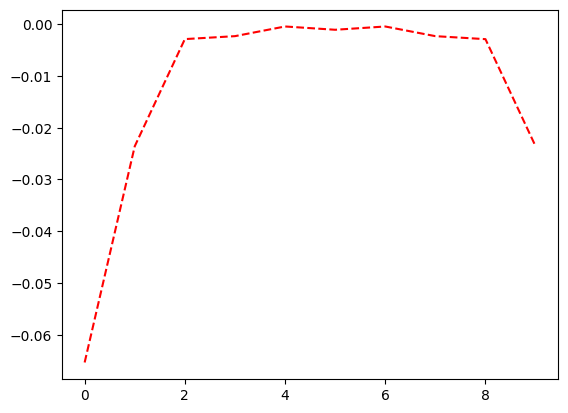

In [43]:
import matplotlib.pyplot as plt


t = np.array(range(0,Nt,1))
plt.errorbar(t, cmean, yerr=csigma, fmt='r--', label='fit')